In [7]:
#IMPORTS put all here
import random
import matplotlib.pyplot as plt

from datetime import datetime

#tf imports for reading file
import numpy as np
import os
import PIL


import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import layers

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow import keras


from tensorflow.keras.regularizers import l2

#extras
print(tf.__version__)
import pathlib
import shutil

2.8.0


In [8]:
# # wandb
# import wandb

# wandb.init(project="GuessFlatKNN")


In [9]:
#path to image dataset
spec_path = 'content/spectrograms6sec'

genre_list=os.listdir(spec_path)
genre_list


['indian_indie',
 'hindustani_classical',
 'classic_bollywood',
 'carnatic',
 'desi_pop',
 'tamil_pop',
 'punjabi_hip_hop',
 'ghazal',
 'sufi',
 'bhojpuri_pop']

In [10]:
#resets the experiment
#%rm -rf content/spectrograms6secnew

In [11]:
# os.mkdir('content/spectrograms6secnew')
# dest_path='content/spectrograms6secnew'

# for genre in genre_list:
#   os.mkdir(f'content/spectrograms6secnew/{genre}')



# #no of samples per class
# n=3000
# cnt=0

# random.seed(123)

# for genre in genre_list:
#   genre_path=os.path.join(spec_path,genre)
#   dest_genre_path=os.path.join(dest_path,genre)

#   #shuffling and selecting 3000 samples
#   genre_songs=os.listdir(genre_path)
#   random.shuffle(genre_songs)
#   selected_spec=genre_songs[:n]
  
#   for song in selected_spec:
#       source=os.path.join(genre_path,song)
#       dest=os.path.join(dest_genre_path,song)
#       d= shutil.copyfile(source, dest)




In [12]:
dest_path='content/spectrograms6secnew'
data_dir=pathlib.Path(dest_path)
data_dir

PosixPath('content/spectrograms6secnew')

In [13]:
#adding dataset
batch_size=64
image_height=100
image_width=200


In [14]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(image_height, image_width),
  batch_size=batch_size)

Found 30000 files belonging to 10 classes.
Using 24000 files for training.


2022-11-08 21:15:54.509367: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-08 21:15:54.509957: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-08 21:15:54.510594: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (CoderCatA5Pop): /proc/driver/nvidia/version does not exist
2022-11-08 21:15:54.524986: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(image_height, image_width),
  batch_size=batch_size)


Found 30000 files belonging to 10 classes.
Using 6000 files for validation.


['bhojpuri_pop', 'carnatic', 'classic_bollywood', 'desi_pop', 'ghazal', 'hindustani_classical', 'indian_indie', 'punjabi_hip_hop', 'sufi', 'tamil_pop']


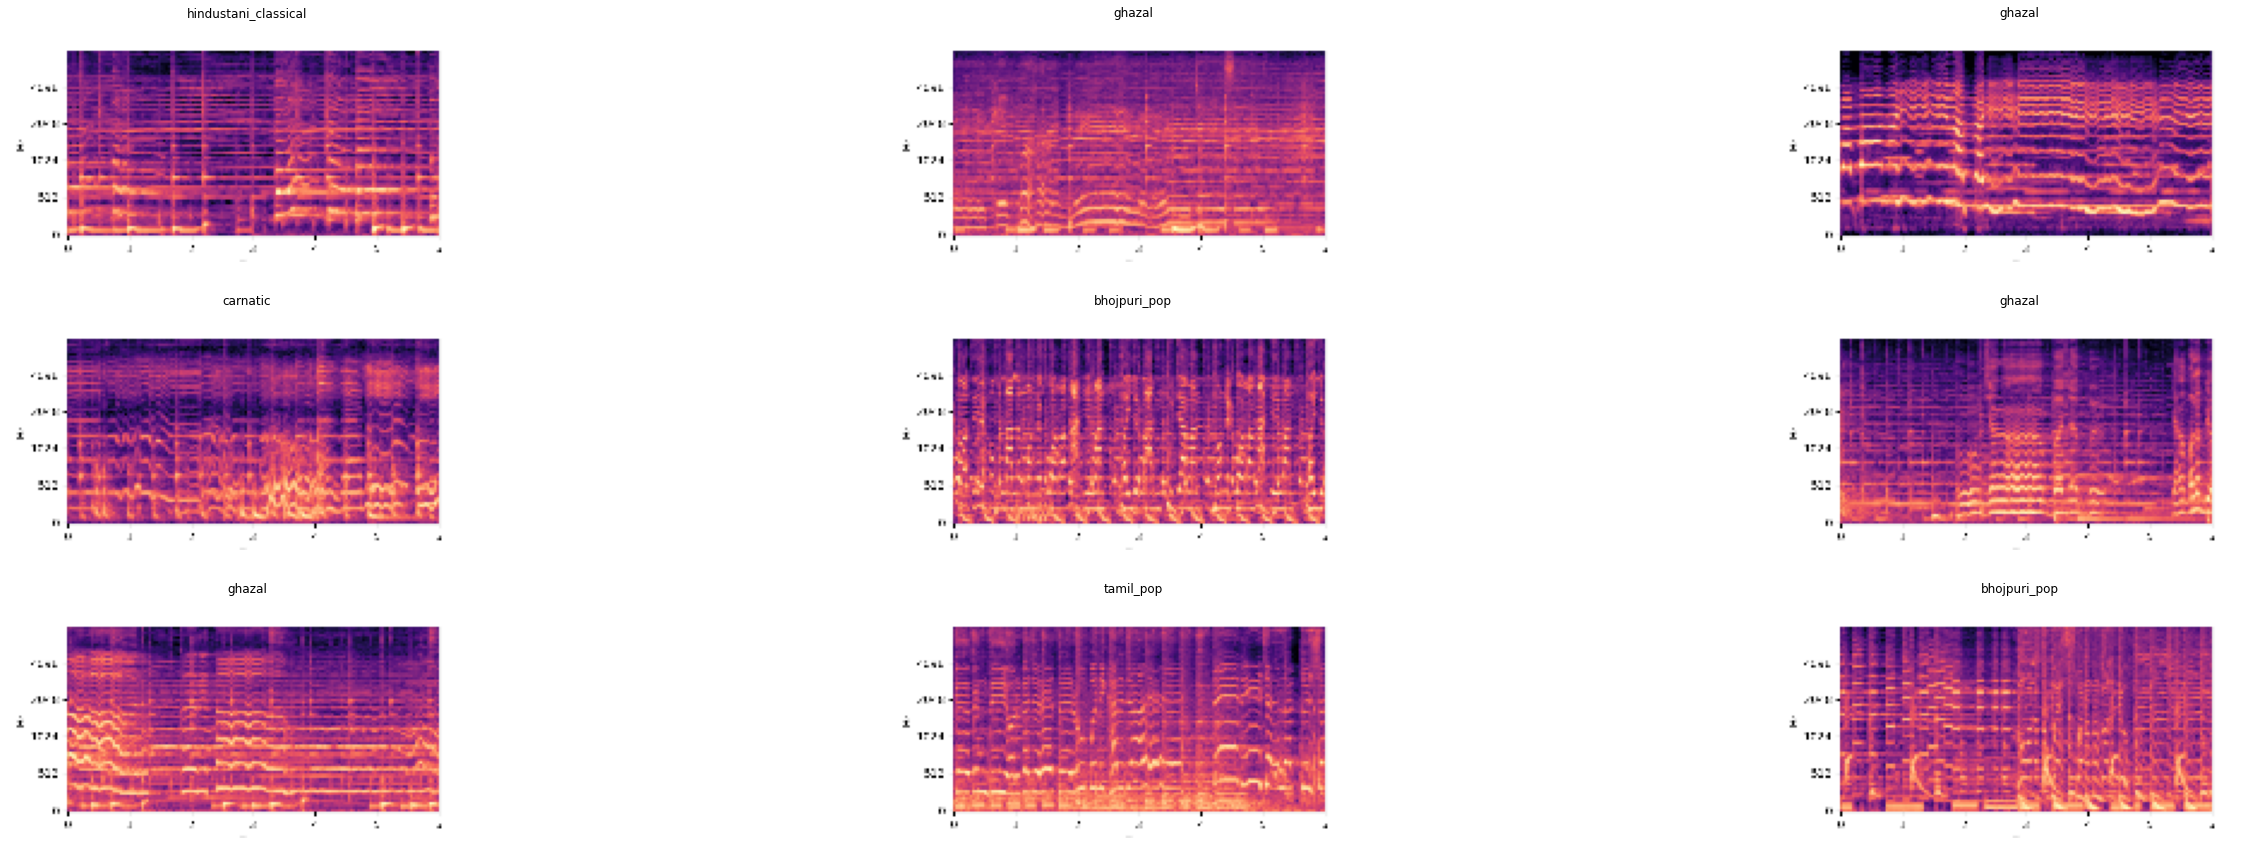

In [16]:
class_names = train_ds.class_names
print(class_names)

import matplotlib.pyplot as plt

plt.figure(figsize=(45, 15))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [17]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 100, 200, 3)
(64,)


In [18]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [19]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [20]:
%load_ext tensorboard

https://www.analyticsvidhya.com/blog/2021/06/build-an-image-classifier-with-svm/

```num_classes = len(class_names)
model = Sequential([
  layers.Rescaling(1./255, input_shape=(image_height, image_width, 3)),
  layers.Conv2D(8, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(8, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(8, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,kernel_regularizer=l2(0.1),activation = "linear")
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

epochs=10

logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    verbose=1,
    callbacks=[tensorboard_callback],
    )
```    
```
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 rescaling_1 (Rescaling)     (None, 100, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 100, 200, 8)       224       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 100, 8)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 100, 8)        584       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 50, 8)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 25, 50, 8)         584       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 25, 8)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 2400)              0         
                                                                 
 dense (Dense)               (None, 128)               307328    
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
=================================================================
Total params: 310,010
Trainable params: 310,010
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
375/375 [==============================] - 74s 196ms/step - loss: 2.2623 - accuracy: 0.3075 - val_loss: 1.6648 - val_accuracy: 0.4308
Epoch 2/10
375/375 [==============================] - 59s 158ms/step - loss: 1.5592 - accuracy: 0.4706 - val_loss: 1.4404 - val_accuracy: 0.5148
Epoch 3/10
375/375 [==============================] - 59s 157ms/step - loss: 1.4090 - accuracy: 0.5218 - val_loss: 1.3409 - val_accuracy: 0.5468
Epoch 4/10
375/375 [==============================] - 60s 160ms/step - loss: 1.3104 - accuracy: 0.5547 - val_loss: 1.2978 - val_accuracy: 0.5593
Epoch 5/10
375/375 [==============================] - 60s 159ms/step - loss: 1.2449 - accuracy: 0.5756 - val_loss: 1.2815 - val_accuracy: 0.5635
Epoch 6/10
375/375 [==============================] - 60s 160ms/step - loss: 1.1922 - accuracy: 0.5961 - val_loss: 1.2569 - val_accuracy: 0.5680
Epoch 7/10
375/375 [==============================] - 60s 159ms/step - loss: 1.1447 - accuracy: 0.6117 - val_loss: 1.2418 - val_accuracy: 0.5708
Epoch 8/10
375/375 [==============================] - 60s 159ms/step - loss: 1.1051 - accuracy: 0.6263 - val_loss: 1.2169 - val_accuracy: 0.5837
Epoch 9/10
375/375 [==============================] - 59s 158ms/step - loss: 1.0668 - accuracy: 0.6423 - val_loss: 1.2056 - val_accuracy: 0.5920
Epoch 10/10
375/375 [==============================] - 59s 157ms/step - loss: 1.0309 - accuracy: 0.6553 - val_loss: 1.1923 - val_accuracy: 0.5960

```

```
num_classes = len(class_names)
model = Sequential([
  layers.Rescaling(1./255, input_shape=(image_height, image_width, 3)),
  layers.Conv2D(8, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(8, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,kernel_regularizer=l2(0.1),activation = "linear")
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

epochs=10

logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    verbose=1,
    callbacks=[tensorboard_callback],
    )

``` 
```
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 rescaling_2 (Rescaling)     (None, 100, 200, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 100, 200, 8)       224       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 50, 100, 8)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 50, 100, 8)        584       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 25, 50, 8)        0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 25, 50, 16)        1168      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 12, 25, 16)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 4800)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               614528    
                                                                 
 dense_3 (Dense)             (None, 10)                1290      
                                                                 
=================================================================
Total params: 617,794
Trainable params: 617,794
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
375/375 [==============================] - 62s 164ms/step - loss: 2.2650 - accuracy: 0.3216 - val_loss: 1.7145 - val_accuracy: 0.4247
Epoch 2/10
375/375 [==============================] - 62s 165ms/step - loss: 1.6195 - accuracy: 0.4505 - val_loss: 1.5137 - val_accuracy: 0.4913
Epoch 3/10
375/375 [==============================] - 61s 162ms/step - loss: 1.4708 - accuracy: 0.4980 - val_loss: 1.4116 - val_accuracy: 0.5223
Epoch 4/10
375/375 [==============================] - 60s 161ms/step - loss: 1.3679 - accuracy: 0.5315 - val_loss: 1.3313 - val_accuracy: 0.5438
Epoch 5/10
375/375 [==============================] - 61s 162ms/step - loss: 1.2876 - accuracy: 0.5608 - val_loss: 1.2964 - val_accuracy: 0.5633
Epoch 6/10
375/375 [==============================] - 62s 164ms/step - loss: 1.2221 - accuracy: 0.5821 - val_loss: 1.2843 - val_accuracy: 0.5683
Epoch 7/10
375/375 [==============================] - 61s 163ms/step - loss: 1.1688 - accuracy: 0.6044 - val_loss: 1.2604 - val_accuracy: 0.5770
Epoch 8/10
375/375 [==============================] - 55s 146ms/step - loss: 1.1239 - accuracy: 0.6226 - val_loss: 1.2368 - val_accuracy: 0.5827
Epoch 9/10
375/375 [==============================] - 55s 147ms/step - loss: 1.0840 - accuracy: 0.6337 - val_loss: 1.2232 - val_accuracy: 0.5950
Epoch 10/10
375/375 [==============================] - 55s 146ms/step - loss: 1.0478 - accuracy: 0.6492 - val_loss: 1.2187 - val_accuracy: 0.5948

````

```
num_classes = len(class_names)
model = Sequential([
  layers.Rescaling(1./255, input_shape=(image_height, image_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(8, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,kernel_regularizer=l2(0.1),activation = "linear")
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

epochs=10

logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    verbose=1,
    callbacks=[tensorboard_callback],
    )
```
```
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 rescaling_3 (Rescaling)     (None, 100, 200, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 100, 200, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 50, 100, 16)      0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 50, 100, 16)       2320      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 25, 50, 16)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 25, 50, 8)         1160      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 12, 25, 8)        0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 2400)              0         
                                                                 
 dense_4 (Dense)             (None, 128)               307328    
                                                                 
 dense_5 (Dense)             (None, 10)                1290      
                                                                 
=================================================================
Total params: 312,546
Trainable params: 312,546
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
375/375 [==============================] - 83s 221ms/step - loss: 2.2252 - accuracy: 0.3388 - val_loss: 1.6295 - val_accuracy: 0.4635
Epoch 2/10
375/375 [==============================] - 92s 245ms/step - loss: 1.5500 - accuracy: 0.4755 - val_loss: 1.4613 - val_accuracy: 0.5030
Epoch 3/10
375/375 [==============================] - 91s 242ms/step - loss: 1.4138 - accuracy: 0.5154 - val_loss: 1.3537 - val_accuracy: 0.5407
Epoch 4/10
375/375 [==============================] - 90s 240ms/step - loss: 1.3120 - accuracy: 0.5497 - val_loss: 1.2868 - val_accuracy: 0.5602
Epoch 5/10
375/375 [==============================] - 90s 241ms/step - loss: 1.2237 - accuracy: 0.5813 - val_loss: 1.2754 - val_accuracy: 0.5607
Epoch 6/10
375/375 [==============================] - 90s 241ms/step - loss: 1.1532 - accuracy: 0.6104 - val_loss: 1.2355 - val_accuracy: 0.5797
Epoch 7/10
375/375 [==============================] - 90s 240ms/step - loss: 1.0923 - accuracy: 0.6325 - val_loss: 1.1899 - val_accuracy: 0.5960
Epoch 8/10
375/375 [==============================] - 92s 245ms/step - loss: 1.0378 - accuracy: 0.6533 - val_loss: 1.1966 - val_accuracy: 0.5965
Epoch 9/10
375/375 [==============================] - 92s 246ms/step - loss: 0.9849 - accuracy: 0.6738 - val_loss: 1.1931 - val_accuracy: 0.6027
Epoch 10/10
375/375 [==============================] - 91s 243ms/step - loss: 0.9363 - accuracy: 0.6929 - val_loss: 1.2020 - val_accuracy: 0.6000

```    

```num_classes = len(class_names)
model = Sequential([
  layers.Rescaling(1./255, input_shape=(image_height, image_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,kernel_regularizer=l2(0.1),activation = "linear")
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

epochs=10

logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    verbose=1,
    callbacks=[tensorboard_callback],
    )
```
```
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 rescaling_4 (Rescaling)     (None, 100, 200, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 100, 200, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 50, 100, 16)      0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 50, 100, 16)       2320      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 25, 50, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 25, 50, 16)        2320      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 12, 25, 16)       0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 4800)              0         
                                                                 
 dense_6 (Dense)             (None, 128)               614528    
                                                                 
 dense_7 (Dense)             (None, 10)                1290      
                                                                 
=================================================================
Total params: 620,906
Trainable params: 620,906
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
375/375 [==============================] - 93s 248ms/step - loss: 2.1485 - accuracy: 0.3612 - val_loss: 1.5848 - val_accuracy: 0.4700
Epoch 2/10
375/375 [==============================] - 93s 247ms/step - loss: 1.4924 - accuracy: 0.4921 - val_loss: 1.3884 - val_accuracy: 0.5285
Epoch 3/10
375/375 [==============================] - 92s 247ms/step - loss: 1.3265 - accuracy: 0.5487 - val_loss: 1.2716 - val_accuracy: 0.5692
Epoch 4/10
375/375 [==============================] - 92s 246ms/step - loss: 1.2143 - accuracy: 0.5914 - val_loss: 1.2176 - val_accuracy: 0.5910
Epoch 5/10
375/375 [==============================] - 91s 243ms/step - loss: 1.1314 - accuracy: 0.6175 - val_loss: 1.1760 - val_accuracy: 0.6048
Epoch 6/10
375/375 [==============================] - 91s 243ms/step - loss: 1.0603 - accuracy: 0.6460 - val_loss: 1.1394 - val_accuracy: 0.6150
Epoch 7/10
375/375 [==============================] - 91s 243ms/step - loss: 0.9945 - accuracy: 0.6700 - val_loss: 1.1136 - val_accuracy: 0.6277
Epoch 8/10
375/375 [==============================] - 92s 244ms/step - loss: 0.9371 - accuracy: 0.6905 - val_loss: 1.0944 - val_accuracy: 0.6373
Epoch 9/10
375/375 [==============================] - 92s 246ms/step - loss: 0.8794 - accuracy: 0.7120 - val_loss: 1.1033 - val_accuracy: 0.6350
Epoch 10/10
375/375 [==============================] - 92s 245ms/step - loss: 0.8294 - accuracy: 0.7300 - val_loss: 1.0940 - val_accuracy: 0.6412

```    

```
num_classes = len(class_names)
model = Sequential([
  layers.Rescaling(1./255, input_shape=(image_height, image_width, 3)),
  layers.Conv2D(8, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(8, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,kernel_regularizer=l2(0.1),activation = "linear")
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

epochs=10

logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    verbose=1,
    callbacks=[tensorboard_callback],
    )
```
```
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 rescaling_5 (Rescaling)     (None, 100, 200, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 100, 200, 8)       224       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 50, 100, 8)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 50, 100, 8)        584       
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 25, 50, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 25, 50, 32)        2336      
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 12, 25, 32)       0         
 g2D)                                                            
                                                                 
 flatten_4 (Flatten)         (None, 9600)              0         
                                                                 
 dense_8 (Dense)             (None, 128)               1228928   
                                                                 
 dense_9 (Dense)             (None, 10)                1290      
                                                                 
=================================================================
Total params: 1,233,362
Trainable params: 1,233,362
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
375/375 [==============================] - 65s 171ms/step - loss: 2.2243 - accuracy: 0.3294 - val_loss: 1.6167 - val_accuracy: 0.4610
Epoch 2/10
375/375 [==============================] - 63s 169ms/step - loss: 1.4884 - accuracy: 0.5006 - val_loss: 1.4157 - val_accuracy: 0.5247
Epoch 3/10
375/375 [==============================] - 63s 168ms/step - loss: 1.3441 - accuracy: 0.5443 - val_loss: 1.3189 - val_accuracy: 0.5583
Epoch 4/10
375/375 [==============================] - 65s 172ms/step - loss: 1.2550 - accuracy: 0.5771 - val_loss: 1.2648 - val_accuracy: 0.5768
Epoch 5/10
375/375 [==============================] - 64s 170ms/step - loss: 1.1864 - accuracy: 0.5977 - val_loss: 1.2594 - val_accuracy: 0.5790
Epoch 6/10
375/375 [==============================] - 64s 170ms/step - loss: 1.1203 - accuracy: 0.6243 - val_loss: 1.2190 - val_accuracy: 0.5900
Epoch 7/10
375/375 [==============================] - 65s 172ms/step - loss: 1.0582 - accuracy: 0.6490 - val_loss: 1.1723 - val_accuracy: 0.6120
Epoch 8/10
375/375 [==============================] - 65s 173ms/step - loss: 1.0039 - accuracy: 0.6675 - val_loss: 1.1567 - val_accuracy: 0.6227
Epoch 9/10
375/375 [==============================] - 65s 173ms/step - loss: 0.9534 - accuracy: 0.6870 - val_loss: 1.1534 - val_accuracy: 0.6243
Epoch 10/10
375/375 [==============================] - 64s 172ms/step - loss: 0.9009 - accuracy: 0.7101 - val_loss: 1.1580 - val_accuracy: 0.6257

```    

```
num_classes = len(class_names)
model = Sequential([
  layers.Rescaling(1./255, input_shape=(image_height, image_width, 3)),
  layers.Conv2D(8, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,kernel_regularizer=l2(0.1),activation = "linear")
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

epochs=10

logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    verbose=1,
    callbacks=[tensorboard_callback],
    )
```
```
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 rescaling_6 (Rescaling)     (None, 100, 200, 3)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 100, 200, 8)       224       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 50, 100, 8)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 50, 100, 32)       2336      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 25, 50, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 25, 50, 32)        9248      
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 12, 25, 32)       0         
 g2D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 9600)              0         
                                                                 
 dense_10 (Dense)            (None, 128)               1228928   
                                                                 
 dense_11 (Dense)            (None, 10)                1290      
                                                                 
=================================================================
Total params: 1,242,026
Trainable params: 1,242,026
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
375/375 [==============================] - 89s 236ms/step - loss: 2.3001 - accuracy: 0.2930 - val_loss: 1.6863 - val_accuracy: 0.4203
Epoch 2/10
375/375 [==============================] - 88s 234ms/step - loss: 1.5817 - accuracy: 0.4532 - val_loss: 1.4649 - val_accuracy: 0.5035
Epoch 3/10
375/375 [==============================] - 91s 243ms/step - loss: 1.4090 - accuracy: 0.5120 - val_loss: 1.3553 - val_accuracy: 0.5385
Epoch 4/10
375/375 [==============================] - 90s 239ms/step - loss: 1.2964 - accuracy: 0.5549 - val_loss: 1.2788 - val_accuracy: 0.5677
Epoch 5/10
375/375 [==============================] - 91s 242ms/step - loss: 1.2082 - accuracy: 0.5865 - val_loss: 1.2253 - val_accuracy: 0.5903
Epoch 6/10
375/375 [==============================] - 91s 242ms/step - loss: 1.1398 - accuracy: 0.6132 - val_loss: 1.2081 - val_accuracy: 0.5978
Epoch 7/10
375/375 [==============================] - 89s 238ms/step - loss: 1.0794 - accuracy: 0.6350 - val_loss: 1.1595 - val_accuracy: 0.6140
Epoch 8/10
375/375 [==============================] - 88s 235ms/step - loss: 1.0339 - accuracy: 0.6536 - val_loss: 1.1404 - val_accuracy: 0.6185
Epoch 9/10
375/375 [==============================] - 88s 235ms/step - loss: 0.9825 - accuracy: 0.6718 - val_loss: 1.1225 - val_accuracy: 0.6235
Epoch 10/10
375/375 [==============================] - 88s 235ms/step - loss: 0.9337 - accuracy: 0.6915 - val_loss: 1.1085 - val_accuracy: 0.6293

```    


```
num_classes = len(class_names)
model = Sequential([
  layers.Rescaling(1./255, input_shape=(image_height, image_width, 3)),
  layers.Conv2D(8, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,kernel_regularizer=l2(0.1),activation = "linear")
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

epochs=10

logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    verbose=1,
    callbacks=[tensorboard_callback],
    )
```    
```
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 rescaling_7 (Rescaling)     (None, 100, 200, 3)       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 100, 200, 8)       224       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 50, 100, 8)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 50, 100, 16)       1168      
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 25, 50, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 25, 50, 32)        4640      
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 12, 25, 32)       0         
 g2D)                                                            
                                                                 
 flatten_6 (Flatten)         (None, 9600)              0         
                                                                 
 dense_12 (Dense)            (None, 128)               1228928   
                                                                 
 dense_13 (Dense)            (None, 10)                1290      
                                                                 
=================================================================
Total params: 1,236,250
Trainable params: 1,236,250
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
375/375 [==============================] - 72s 192ms/step - loss: 2.2666 - accuracy: 0.3045 - val_loss: 1.6276 - val_accuracy: 0.4485
Epoch 2/10
375/375 [==============================] - 72s 191ms/step - loss: 1.5441 - accuracy: 0.4668 - val_loss: 1.4383 - val_accuracy: 0.5093
Epoch 3/10
375/375 [==============================] - 70s 186ms/step - loss: 1.3865 - accuracy: 0.5272 - val_loss: 1.3068 - val_accuracy: 0.5548
Epoch 4/10
375/375 [==============================] - 70s 187ms/step - loss: 1.2696 - accuracy: 0.5652 - val_loss: 1.2655 - val_accuracy: 0.5648
Epoch 5/10
375/375 [==============================] - 73s 194ms/step - loss: 1.1885 - accuracy: 0.5968 - val_loss: 1.2185 - val_accuracy: 0.5732
Epoch 6/10
375/375 [==============================] - 72s 191ms/step - loss: 1.1283 - accuracy: 0.6179 - val_loss: 1.1763 - val_accuracy: 0.5922
Epoch 7/10
375/375 [==============================] - 71s 189ms/step - loss: 1.0791 - accuracy: 0.6349 - val_loss: 1.1498 - val_accuracy: 0.6018
Epoch 8/10
375/375 [==============================] - 70s 186ms/step - loss: 1.0307 - accuracy: 0.6541 - val_loss: 1.1286 - val_accuracy: 0.6152
Epoch 9/10
375/375 [==============================] - 70s 186ms/step - loss: 0.9879 - accuracy: 0.6704 - val_loss: 1.1251 - val_accuracy: 0.6167
Epoch 10/10
375/375 [==============================] - 70s 187ms/step - loss: 0.9443 - accuracy: 0.6855 - val_loss: 1.1194 - val_accuracy: 0.6177

```

```
num_classes = len(class_names)
model = Sequential([
  layers.Rescaling(1./255, input_shape=(image_height, image_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,kernel_regularizer=l2(0.1),activation = "linear")
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

epochs=10

logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    verbose=1,
    callbacks=[tensorboard_callback],
    )
```
```
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 rescaling_8 (Rescaling)     (None, 100, 200, 3)       0         
                                                                 
 conv2d_21 (Conv2D)          (None, 100, 200, 16)      448       
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 50, 100, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 50, 100, 16)       2320      
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 25, 50, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 25, 50, 32)        4640      
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 12, 25, 32)       0         
 g2D)                                                            
                                                                 
 flatten_7 (Flatten)         (None, 9600)              0         
                                                                 
 dense_14 (Dense)            (None, 128)               1228928   
                                                                 
 dense_15 (Dense)            (None, 10)                1290      
                                                                 
=================================================================
Total params: 1,237,626
Trainable params: 1,237,626
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
375/375 [==============================] - 96s 254ms/step - loss: 2.1072 - accuracy: 0.3997 - val_loss: 1.5087 - val_accuracy: 0.5088
Epoch 2/10
375/375 [==============================] - 94s 251ms/step - loss: 1.3834 - accuracy: 0.5426 - val_loss: 1.2786 - val_accuracy: 0.5797
Epoch 3/10
375/375 [==============================] - 94s 250ms/step - loss: 1.2286 - accuracy: 0.5861 - val_loss: 1.2022 - val_accuracy: 0.5945
Epoch 4/10
375/375 [==============================] - 94s 252ms/step - loss: 1.1162 - accuracy: 0.6273 - val_loss: 1.1626 - val_accuracy: 0.6053
Epoch 5/10
375/375 [==============================] - 94s 250ms/step - loss: 1.0217 - accuracy: 0.6591 - val_loss: 1.0904 - val_accuracy: 0.6320
Epoch 6/10
375/375 [==============================] - 94s 250ms/step - loss: 0.9414 - accuracy: 0.6889 - val_loss: 1.0654 - val_accuracy: 0.6455
Epoch 7/10
375/375 [==============================] - 94s 252ms/step - loss: 0.8565 - accuracy: 0.7213 - val_loss: 1.0556 - val_accuracy: 0.6515
Epoch 8/10
375/375 [==============================] - 94s 252ms/step - loss: 0.7869 - accuracy: 0.7470 - val_loss: 1.0987 - val_accuracy: 0.6468
Epoch 9/10
375/375 [==============================] - 94s 252ms/step - loss: 0.7193 - accuracy: 0.7719 - val_loss: 1.1533 - val_accuracy: 0.6388
Epoch 10/10
375/375 [==============================] - 94s 251ms/step - loss: 0.6688 - accuracy: 0.7907 - val_loss: 1.2124 - val_accuracy: 0.6312

```    

```
num_classes = len(class_names)
model = Sequential([
  layers.Rescaling(1./255, input_shape=(image_height, image_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,kernel_regularizer=l2(0.1),activation = "linear")
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

epochs=10

logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    verbose=1,
    callbacks=[tensorboard_callback],
    )
```    
```
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 rescaling_9 (Rescaling)     (None, 100, 200, 3)       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 100, 200, 16)      448       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 50, 100, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 50, 100, 32)       4640      
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 25, 50, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 25, 50, 32)        9248      
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 12, 25, 32)       0         
 g2D)                                                            
                                                                 
 flatten_8 (Flatten)         (None, 9600)              0         
                                                                 
 dense_16 (Dense)            (None, 128)               1228928   
                                                                 
 dense_17 (Dense)            (None, 10)                1290      
                                                                 
=================================================================
Total params: 1,244,554
Trainable params: 1,244,554
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
375/375 [==============================] - 116s 308ms/step - loss: 2.2948 - accuracy: 0.2899 - val_loss: 1.7012 - val_accuracy: 0.4222
Epoch 2/10
375/375 [==============================] - 114s 303ms/step - loss: 1.5894 - accuracy: 0.4535 - val_loss: 1.4437 - val_accuracy: 0.5103
Epoch 3/10
375/375 [==============================] - 113s 300ms/step - loss: 1.3968 - accuracy: 0.5170 - val_loss: 1.3053 - val_accuracy: 0.5515
Epoch 4/10
375/375 [==============================] - 113s 300ms/step - loss: 1.2792 - accuracy: 0.5589 - val_loss: 1.2335 - val_accuracy: 0.5767
Epoch 5/10
375/375 [==============================] - 114s 303ms/step - loss: 1.1957 - accuracy: 0.5903 - val_loss: 1.1897 - val_accuracy: 0.5997
Epoch 6/10
375/375 [==============================] - 111s 296ms/step - loss: 1.1306 - accuracy: 0.6158 - val_loss: 1.1818 - val_accuracy: 0.6002
Epoch 7/10
375/375 [==============================] - 112s 298ms/step - loss: 1.0768 - accuracy: 0.6335 - val_loss: 1.1931 - val_accuracy: 0.5957
Epoch 8/10
375/375 [==============================] - 113s 302ms/step - loss: 1.0252 - accuracy: 0.6560 - val_loss: 1.1627 - val_accuracy: 0.6102
Epoch 9/10
375/375 [==============================] - 115s 305ms/step - loss: 0.9860 - accuracy: 0.6680 - val_loss: 1.1552 - val_accuracy: 0.6133
Epoch 10/10
375/375 [==============================] - 113s 302ms/step - loss: 0.9446 - accuracy: 0.6846 - val_loss: 1.1578 - val_accuracy: 0.6140

```

```
num_classes = len(class_names)
model = Sequential([
  layers.Rescaling(1./255, input_shape=(image_height, image_width, 3)),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,kernel_regularizer=l2(0.1),activation = "linear")
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

epochs=10

logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    verbose=1,
    callbacks=[tensorboard_callback],
    )
    
```
```
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 rescaling_10 (Rescaling)    (None, 100, 200, 3)       0         
                                                                 
 conv2d_27 (Conv2D)          (None, 100, 200, 32)      896       
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 50, 100, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 50, 100, 32)       9248      
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 25, 50, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 25, 50, 32)        9248      
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 12, 25, 32)       0         
 g2D)                                                            
                                                                 
 flatten_9 (Flatten)         (None, 9600)              0         
                                                                 
 dense_18 (Dense)            (None, 128)               1228928   
                                                                 
 dense_19 (Dense)            (None, 10)                1290      
                                                                 
=================================================================
Total params: 1,249,610
Trainable params: 1,249,610
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
375/375 [==============================] - 177s 470ms/step - loss: 2.2981 - accuracy: 0.2937 - val_loss: 1.6363 - val_accuracy: 0.4423
Epoch 2/10
375/375 [==============================] - 174s 465ms/step - loss: 1.4864 - accuracy: 0.4913 - val_loss: 1.3556 - val_accuracy: 0.5398
Epoch 3/10
375/375 [==============================] - 173s 461ms/step - loss: 1.2773 - accuracy: 0.5605 - val_loss: 1.2428 - val_accuracy: 0.5742
Epoch 4/10
375/375 [==============================] - 172s 460ms/step - loss: 1.1580 - accuracy: 0.6035 - val_loss: 1.2110 - val_accuracy: 0.5895
Epoch 5/10
375/375 [==============================] - 171s 456ms/step - loss: 1.0663 - accuracy: 0.6370 - val_loss: 1.1687 - val_accuracy: 0.6042
Epoch 6/10
375/375 [==============================] - 172s 459ms/step - loss: 0.9764 - accuracy: 0.6715 - val_loss: 1.1442 - val_accuracy: 0.6215
Epoch 7/10
375/375 [==============================] - 173s 461ms/step - loss: 0.8975 - accuracy: 0.7002 - val_loss: 1.1639 - val_accuracy: 0.6207
Epoch 8/10
375/375 [==============================] - 174s 463ms/step - loss: 0.8212 - accuracy: 0.7300 - val_loss: 1.1914 - val_accuracy: 0.6225
Epoch 9/10
375/375 [==============================] - 171s 457ms/step - loss: 0.7514 - accuracy: 0.7548 - val_loss: 1.1607 - val_accuracy: 0.6345
Epoch 10/10
375/375 [==============================] - 174s 465ms/step - loss: 0.6893 - accuracy: 0.7801 - val_loss: 1.1689 - val_accuracy: 0.6425

```

```
num_classes = len(class_names)
model = Sequential([
  layers.Rescaling(1./255, input_shape=(image_height, image_width, 3)),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,kernel_regularizer=l2(0.1),activation = "linear")
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

epochs=10

logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    verbose=1,
    callbacks=[tensorboard_callback],
    )
```
```
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 rescaling_11 (Rescaling)    (None, 100, 200, 3)       0         
                                                                 
 conv2d_30 (Conv2D)          (None, 100, 200, 64)      1792      
                                                                 
 conv2d_31 (Conv2D)          (None, 100, 200, 32)      18464     
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 50, 100, 32)      0         
 g2D)                                                            
                                                                 
 flatten_10 (Flatten)        (None, 160000)            0         
                                                                 
 dense_20 (Dense)            (None, 128)               20480128  
                                                                 
 dense_21 (Dense)            (None, 10)                1290      
                                                                 
=================================================================
Total params: 20,501,674
Trainable params: 20,501,674
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
375/375 [==============================] - 778s 2s/step - loss: 2.4174 - accuracy: 0.3769 - val_loss: 1.6143 - val_accuracy: 0.5218
Epoch 2/10
375/375 [==============================] - 787s 2s/step - loss: 1.4109 - accuracy: 0.5681 - val_loss: 1.3254 - val_accuracy: 0.5812
Epoch 3/10
375/375 [==============================] - 782s 2s/step - loss: 1.0843 - accuracy: 0.6572 - val_loss: 1.2022 - val_accuracy: 0.6143
Epoch 4/10
375/375 [==============================] - 790s 2s/step - loss: 0.8308 - accuracy: 0.7450 - val_loss: 1.1695 - val_accuracy: 0.6292
Epoch 5/10
375/375 [==============================] - 789s 2s/step - loss: 0.6378 - accuracy: 0.8133 - val_loss: 1.2545 - val_accuracy: 0.6185
Epoch 6/10
375/375 [==============================] - 790s 2s/step - loss: 0.4990 - accuracy: 0.8580 - val_loss: 1.4241 - val_accuracy: 0.6032
Epoch 7/10
375/375 [==============================] - 790s 2s/step - loss: 0.4040 - accuracy: 0.8930 - val_loss: 1.6077 - val_accuracy: 0.6052
Epoch 8/10
375/375 [==============================] - 790s 2s/step - loss: 0.3246 - accuracy: 0.9196 - val_loss: 1.6012 - val_accuracy: 0.6202
Epoch 9/10
375/375 [==============================] - 796s 2s/step - loss: 0.2647 - accuracy: 0.9377 - val_loss: 1.8238 - val_accuracy: 0.6140
Epoch 10/10
375/375 [==============================] - 798s 2s/step - loss: 0.2034 - accuracy: 0.9575 - val_loss: 1.8795 - val_accuracy: 0.6288

    
```

```
num_classes = len(class_names)
model = Sequential([
  layers.Rescaling(1./255, input_shape=(image_height, image_width, 3)),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,kernel_regularizer=l2(0.1),activation = "linear")
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

epochs=10

logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    verbose=1,
    callbacks=[tensorboard_callback],
    )
    
```
```
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 rescaling_11 (Rescaling)    (None, 100, 200, 3)       0         
                                                                 
 conv2d_30 (Conv2D)          (None, 100, 200, 64)      1792      
                                                                 
 conv2d_31 (Conv2D)          (None, 100, 200, 32)      18464     
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 50, 100, 32)      0         
 g2D)                                                            
                                                                 
 flatten_10 (Flatten)        (None, 160000)            0         
                                                                 
 dense_20 (Dense)            (None, 128)               20480128  
                                                                 
 dense_21 (Dense)            (None, 10)                1290      
                                                                 
=================================================================
Total params: 20,501,674
Trainable params: 20,501,674
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
375/375 [==============================] - 778s 2s/step - loss: 2.4174 - accuracy: 0.3769 - val_loss: 1.6143 - val_accuracy: 0.5218
Epoch 2/10
375/375 [==============================] - 787s 2s/step - loss: 1.4109 - accuracy: 0.5681 - val_loss: 1.3254 - val_accuracy: 0.5812
Epoch 3/10
375/375 [==============================] - 782s 2s/step - loss: 1.0843 - accuracy: 0.6572 - val_loss: 1.2022 - val_accuracy: 0.6143
Epoch 4/10
375/375 [==============================] - 790s 2s/step - loss: 0.8308 - accuracy: 0.7450 - val_loss: 1.1695 - val_accuracy: 0.6292
Epoch 5/10
375/375 [==============================] - 789s 2s/step - loss: 0.6378 - accuracy: 0.8133 - val_loss: 1.2545 - val_accuracy: 0.6185
Epoch 6/10
375/375 [==============================] - 790s 2s/step - loss: 0.4990 - accuracy: 0.8580 - val_loss: 1.4241 - val_accuracy: 0.6032
Epoch 7/10
375/375 [==============================] - 790s 2s/step - loss: 0.4040 - accuracy: 0.8930 - val_loss: 1.6077 - val_accuracy: 0.6052
Epoch 8/10
375/375 [==============================] - 790s 2s/step - loss: 0.3246 - accuracy: 0.9196 - val_loss: 1.6012 - val_accuracy: 0.6202
Epoch 9/10
375/375 [==============================] - 796s 2s/step - loss: 0.2647 - accuracy: 0.9377 - val_loss: 1.8238 - val_accuracy: 0.6140
Epoch 10/10
375/375 [==============================] - 798s 2s/step - loss: 0.2034 - accuracy: 0.9575 - val_loss: 1.8795 - val_accuracy: 0.6288

```

```
num_classes = len(class_names)
model = Sequential([
  layers.Rescaling(1./255, input_shape=(image_height, image_width, 3)),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,kernel_regularizer=l2(0.1),activation = "linear")
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

epochs=10

logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    verbose=1,
    callbacks=[tensorboard_callback],
    )
    
```
```
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 rescaling_13 (Rescaling)    (None, 100, 200, 3)       0         
                                                                 
 conv2d_35 (Conv2D)          (None, 100, 200, 32)      896       
                                                                 
 conv2d_36 (Conv2D)          (None, 100, 200, 32)      9248      
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 50, 100, 32)      0         
 g2D)                                                            
                                                                 
 flatten_12 (Flatten)        (None, 160000)            0         
                                                                 
 dense_24 (Dense)            (None, 128)               20480128  
                                                                 
 dense_25 (Dense)            (None, 10)                1290      
                                                                 
=================================================================
Total params: 20,491,562
Trainable params: 20,491,562
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
375/375 [==============================] - 438s 1s/step - loss: 2.5182 - accuracy: 0.3702 - val_loss: 1.7012 - val_accuracy: 0.4942
Epoch 2/10
375/375 [==============================] - 436s 1s/step - loss: 1.3974 - accuracy: 0.5757 - val_loss: 1.2978 - val_accuracy: 0.6008
Epoch 3/10
375/375 [==============================] - 436s 1s/step - loss: 1.0384 - accuracy: 0.6792 - val_loss: 1.2073 - val_accuracy: 0.6203
Epoch 4/10
375/375 [==============================] - 437s 1s/step - loss: 0.8079 - accuracy: 0.7606 - val_loss: 1.2215 - val_accuracy: 0.6270
Epoch 5/10
375/375 [==============================] - 438s 1s/step - loss: 0.6178 - accuracy: 0.8242 - val_loss: 1.3719 - val_accuracy: 0.6152
Epoch 6/10
375/375 [==============================] - 436s 1s/step - loss: 0.4865 - accuracy: 0.8683 - val_loss: 1.4702 - val_accuracy: 0.6118
Epoch 7/10
375/375 [==============================] - 438s 1s/step - loss: 0.4247 - accuracy: 0.8854 - val_loss: 1.4583 - val_accuracy: 0.6147
Epoch 8/10
375/375 [==============================] - 437s 1s/step - loss: 0.3436 - accuracy: 0.9110 - val_loss: 1.7775 - val_accuracy: 0.5987
Epoch 9/10
375/375 [==============================] - 438s 1s/step - loss: 0.2556 - accuracy: 0.9395 - val_loss: 1.7210 - val_accuracy: 0.6175
Epoch 10/10
375/375 [==============================] - 439s 1s/step - loss: 0.2220 - accuracy: 0.9534 - val_loss: 1.6865 - val_accuracy: 0.6258

```

```
num_classes = len(class_names)
model = Sequential([
  layers.Rescaling(1./255, input_shape=(image_height, image_width, 3)),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(8, 4, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,kernel_regularizer=l2(0.1),activation = "linear")
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

epochs=10

logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    verbose=1,
    callbacks=[tensorboard_callback],
    )
    
```
```
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 rescaling_12 (Rescaling)    (None, 100, 200, 3)       0         
                                                                 
 conv2d_32 (Conv2D)          (None, 100, 200, 32)      896       
                                                                 
 conv2d_33 (Conv2D)          (None, 100, 200, 16)      4624      
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 50, 100, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 50, 100, 8)        2056      
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 25, 50, 8)        0         
 g2D)                                                            
                                                                 
 flatten_11 (Flatten)        (None, 10000)             0         
                                                                 
 dense_22 (Dense)            (None, 128)               1280128   
                                                                 
 dense_23 (Dense)            (None, 10)                1290      
                                                                 
=================================================================
Total params: 1,288,994
Trainable params: 1,288,994
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
375/375 [==============================] - 389s 1s/step - loss: 2.1615 - accuracy: 0.3586 - val_loss: 1.5042 - val_accuracy: 0.5017
Epoch 2/10
375/375 [==============================] - 391s 1s/step - loss: 1.3695 - accuracy: 0.5415 - val_loss: 1.2571 - val_accuracy: 0.5825
Epoch 3/10
375/375 [==============================] - 395s 1s/step - loss: 1.1495 - accuracy: 0.6153 - val_loss: 1.1891 - val_accuracy: 0.6050
Epoch 4/10
375/375 [==============================] - 391s 1s/step - loss: 0.9953 - accuracy: 0.6699 - val_loss: 1.1697 - val_accuracy: 0.6205
Epoch 5/10
375/375 [==============================] - 390s 1s/step - loss: 0.8684 - accuracy: 0.7157 - val_loss: 1.1428 - val_accuracy: 0.6342
Epoch 6/10
375/375 [==============================] - 391s 1s/step - loss: 0.7687 - accuracy: 0.7490 - val_loss: 1.1783 - val_accuracy: 0.6470
Epoch 7/10
375/375 [==============================] - 389s 1s/step - loss: 0.6641 - accuracy: 0.7884 - val_loss: 1.2536 - val_accuracy: 0.6343
Epoch 8/10
375/375 [==============================] - 396s 1s/step - loss: 0.5983 - accuracy: 0.8138 - val_loss: 1.3908 - val_accuracy: 0.6028
Epoch 9/10
375/375 [==============================] - 397s 1s/step - loss: 0.5471 - accuracy: 0.8296 - val_loss: 1.4698 - val_accuracy: 0.6148
Epoch 10/10
375/375 [==============================] - 394s 1s/step - loss: 0.4925 - accuracy: 0.8505 - val_loss: 1.5111 - val_accuracy: 0.6160

```

```
num_classes = len(class_names)
model = Sequential([
  layers.Rescaling(1./255, input_shape=(image_height, image_width, 3)),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.Conv2D(8, 5, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(8, 5, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,kernel_regularizer=l2(0.1),activation = "linear")
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

epochs=10

logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    verbose=1,
    callbacks=[tensorboard_callback],
    )
    
```
```
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 rescaling_14 (Rescaling)    (None, 100, 200, 3)       0         
                                                                 
 conv2d_37 (Conv2D)          (None, 100, 200, 32)      896       
                                                                 
 conv2d_38 (Conv2D)          (None, 100, 200, 8)       6408      
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 50, 100, 8)       0         
 g2D)                                                            
                                                                 
 conv2d_39 (Conv2D)          (None, 50, 100, 8)        1608      
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 25, 50, 8)        0         
 g2D)                                                            
                                                                 
 flatten_13 (Flatten)        (None, 10000)             0         
                                                                 
 dense_26 (Dense)            (None, 128)               1280128   
                                                                 
 dense_27 (Dense)            (None, 10)                1290      
                                                                 
=================================================================
Total params: 1,290,330
Trainable params: 1,290,330
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
375/375 [==============================] - 807s 2s/step - loss: 2.1120 - accuracy: 0.3751 - val_loss: 1.4633 - val_accuracy: 0.5130
Epoch 2/10
375/375 [==============================] - 801s 2s/step - loss: 1.3524 - accuracy: 0.5528 - val_loss: 1.2879 - val_accuracy: 0.5708
Epoch 3/10
375/375 [==============================] - 802s 2s/step - loss: 1.1921 - accuracy: 0.6065 - val_loss: 1.2358 - val_accuracy: 0.5850
Epoch 4/10
375/375 [==============================] - 802s 2s/step - loss: 1.0716 - accuracy: 0.6496 - val_loss: 1.1835 - val_accuracy: 0.6090
Epoch 5/10
375/375 [==============================] - 801s 2s/step - loss: 0.9495 - accuracy: 0.6930 - val_loss: 1.2196 - val_accuracy: 0.6067
Epoch 6/10
375/375 [==============================] - 800s 2s/step - loss: 0.8357 - accuracy: 0.7357 - val_loss: 1.2858 - val_accuracy: 0.5943
Epoch 7/10
375/375 [==============================] - 802s 2s/step - loss: 0.7391 - accuracy: 0.7711 - val_loss: 1.3385 - val_accuracy: 0.5920
Epoch 8/10
375/375 [==============================] - 808s 2s/step - loss: 0.6566 - accuracy: 0.7966 - val_loss: 1.4852 - val_accuracy: 0.5847
Epoch 9/10
375/375 [==============================] - 801s 2s/step - loss: 0.5943 - accuracy: 0.8150 - val_loss: 1.5909 - val_accuracy: 0.5805
Epoch 10/10
375/375 [==============================] - 804s 2s/step - loss: 0.5501 - accuracy: 0.8283 - val_loss: 1.5837 - val_accuracy: 0.5852

```

```

num_classes = len(class_names)
model = Sequential([
  layers.Rescaling(1./255, input_shape=(image_height, image_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(8, 4, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,kernel_regularizer=l2(0.1),activation = "linear")
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

epochs=10

logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    verbose=1,
    callbacks=[tensorboard_callback],
    )
    
```
```
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 rescaling_15 (Rescaling)    (None, 100, 200, 3)       0         
                                                                 
 conv2d_40 (Conv2D)          (None, 100, 200, 16)      448       
                                                                 
 conv2d_41 (Conv2D)          (None, 100, 200, 16)      2320      
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 50, 100, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_42 (Conv2D)          (None, 50, 100, 8)        2056      
                                                                 
 max_pooling2d_37 (MaxPoolin  (None, 25, 50, 8)        0         
 g2D)                                                            
                                                                 
 flatten_14 (Flatten)        (None, 10000)             0         
                                                                 
 dense_28 (Dense)            (None, 128)               1280128   
                                                                 
 dense_29 (Dense)            (None, 10)                1290      
                                                                 
=================================================================
Total params: 1,286,242
Trainable params: 1,286,242
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
375/375 [==============================] - 219s 583ms/step - loss: 2.1510 - accuracy: 0.3567 - val_loss: 1.5622 - val_accuracy: 0.4763
Epoch 2/10
375/375 [==============================] - 213s 568ms/step - loss: 1.4070 - accuracy: 0.5288 - val_loss: 1.3431 - val_accuracy: 0.5453
Epoch 3/10
375/375 [==============================] - 214s 572ms/step - loss: 1.2290 - accuracy: 0.5879 - val_loss: 1.2674 - val_accuracy: 0.5753
Epoch 4/10
375/375 [==============================] - 213s 567ms/step - loss: 1.1057 - accuracy: 0.6292 - val_loss: 1.2069 - val_accuracy: 0.5973
Epoch 5/10
375/375 [==============================] - 216s 575ms/step - loss: 0.9985 - accuracy: 0.6702 - val_loss: 1.1687 - val_accuracy: 0.6127
Epoch 6/10
375/375 [==============================] - 213s 569ms/step - loss: 0.9064 - accuracy: 0.7029 - val_loss: 1.2242 - val_accuracy: 0.6052
Epoch 7/10
375/375 [==============================] - 214s 572ms/step - loss: 0.8148 - accuracy: 0.7356 - val_loss: 1.2746 - val_accuracy: 0.5995
Epoch 8/10
375/375 [==============================] - 214s 570ms/step - loss: 0.7357 - accuracy: 0.7640 - val_loss: 1.3318 - val_accuracy: 0.6005
Epoch 9/10
375/375 [==============================] - 216s 575ms/step - loss: 0.6586 - accuracy: 0.7918 - val_loss: 1.4017 - val_accuracy: 0.6017
Epoch 10/10
375/375 [==============================] - 214s 571ms/step - loss: 0.6005 - accuracy: 0.8133 - val_loss: 1.4863 - val_accuracy: 0.5997

```

```
num_classes = len(class_names)
model = Sequential([
  layers.Rescaling(1./255, input_shape=(image_height, image_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.Conv2D(8, 4, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(4, 5, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,kernel_regularizer=l2(0.1),activation = "linear")
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

epochs=10

logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    verbose=1,
    callbacks=[tensorboard_callback],
    )
    
```

```
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 rescaling_16 (Rescaling)    (None, 100, 200, 3)       0         
                                                                 
 conv2d_43 (Conv2D)          (None, 100, 200, 16)      448       
                                                                 
 conv2d_44 (Conv2D)          (None, 100, 200, 8)       2056      
                                                                 
 max_pooling2d_38 (MaxPoolin  (None, 50, 100, 8)       0         
 g2D)                                                            
                                                                 
 conv2d_45 (Conv2D)          (None, 50, 100, 4)        804       
                                                                 
 max_pooling2d_39 (MaxPoolin  (None, 25, 50, 4)        0         
 g2D)                                                            
                                                                 
 flatten_15 (Flatten)        (None, 5000)              0         
                                                                 
 dense_30 (Dense)            (None, 128)               640128    
                                                                 
 dense_31 (Dense)            (None, 10)                1290      
                                                                 
=================================================================
Total params: 644,726
Trainable params: 644,726
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
375/375 [==============================] - 291s 774ms/step - loss: 2.2095 - accuracy: 0.3466 - val_loss: 1.5863 - val_accuracy: 0.4678
Epoch 2/10
375/375 [==============================] - 288s 768ms/step - loss: 1.4577 - accuracy: 0.5151 - val_loss: 1.3943 - val_accuracy: 0.5272
Epoch 3/10
375/375 [==============================] - 289s 770ms/step - loss: 1.3068 - accuracy: 0.5603 - val_loss: 1.3334 - val_accuracy: 0.5462
Epoch 4/10
375/375 [==============================] - 290s 772ms/step - loss: 1.2034 - accuracy: 0.5958 - val_loss: 1.2957 - val_accuracy: 0.5595
Epoch 5/10
375/375 [==============================] - 287s 764ms/step - loss: 1.1153 - accuracy: 0.6255 - val_loss: 1.2758 - val_accuracy: 0.5722
Epoch 6/10
375/375 [==============================] - 287s 764ms/step - loss: 1.0419 - accuracy: 0.6528 - val_loss: 1.2733 - val_accuracy: 0.5757
Epoch 7/10
375/375 [==============================] - 288s 767ms/step - loss: 0.9736 - accuracy: 0.6795 - val_loss: 1.2595 - val_accuracy: 0.5842
Epoch 8/10
375/375 [==============================] - 287s 764ms/step - loss: 0.9118 - accuracy: 0.7035 - val_loss: 1.2549 - val_accuracy: 0.5947
Epoch 9/10
375/375 [==============================] - 288s 767ms/step - loss: 0.8465 - accuracy: 0.7284 - val_loss: 1.2807 - val_accuracy: 0.5947
Epoch 10/10
375/375 [==============================] - 290s 772ms/step - loss: 0.7918 - accuracy: 0.7471 - val_loss: 1.3263 - val_accuracy: 0.5965

```

# TRYING NEW LAYER CONFIGS



```
num_classes = len(class_names)
model = Sequential([
  layers.Rescaling(1./255, input_shape=(image_height, image_width, 3)),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(8, 4, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,kernel_regularizer=l2(0.1),activation = "linear")
])

#hyperparams
opt = keras.optimizers.Adam(learning_rate=0.001)



model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

epochs=10

logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    verbose=1,
    callbacks=[tensorboard_callback],
    )
```
```
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 rescaling_9 (Rescaling)     (None, 100, 200, 3)       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 100, 200, 64)      1792      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 50, 100, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 50, 100, 8)        8200      
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 25, 50, 8)        0         
 g2D)                                                            
                                                                 
 flatten_8 (Flatten)         (None, 10000)             0         
                                                                 
 dense_16 (Dense)            (None, 128)               1280128   
                                                                 
 dense_17 (Dense)            (None, 10)                1290      
                                                                 
=================================================================
Total params: 1,291,410
Trainable params: 1,291,410
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
375/375 [==============================] - 380s 1s/step - loss: 2.3673 - accuracy: 0.2684 - val_loss: 1.7870 - val_accuracy: 0.3685
Epoch 2/10
375/375 [==============================] - 377s 1s/step - loss: 1.7003 - accuracy: 0.4061 - val_loss: 1.6072 - val_accuracy: 0.4338
Epoch 3/10
375/375 [==============================] - 374s 997ms/step - loss: 1.5918 - accuracy: 0.4521 - val_loss: 1.5311 - val_accuracy: 0.4692
Epoch 4/10
375/375 [==============================] - 377s 1s/step - loss: 1.5200 - accuracy: 0.4770 - val_loss: 1.5029 - val_accuracy: 0.4723
Epoch 5/10
375/375 [==============================] - 377s 1s/step - loss: 1.4693 - accuracy: 0.4955 - val_loss: 1.4671 - val_accuracy: 0.4937
Epoch 6/10
375/375 [==============================] - 374s 998ms/step - loss: 1.4236 - accuracy: 0.5117 - val_loss: 1.4539 - val_accuracy: 0.4915
Epoch 7/10
375/375 [==============================] - 375s 999ms/step - loss: 1.3882 - accuracy: 0.5257 - val_loss: 1.4182 - val_accuracy: 0.5083
Epoch 8/10
375/375 [==============================] - 375s 1000ms/step - loss: 1.3547 - accuracy: 0.5383 - val_loss: 1.4040 - val_accuracy: 0.5102
Epoch 9/10
375/375 [==============================] - 375s 1s/step - loss: 1.3251 - accuracy: 0.5507 - val_loss: 1.3895 - val_accuracy: 0.5167
Epoch 10/10
375/375 [==============================] - 377s 1s/step - loss: 1.2959 - accuracy: 0.5609 - val_loss: 1.3806 - val_accuracy: 0.5192

```

```
num_classes = len(class_names)
model = Sequential([
  layers.Rescaling(1./255, input_shape=(image_height, image_width, 3)),
  layers.Conv2D(24, 3, padding='same', activation='relu'),
  layers.Conv2D(16, 4, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(16, 4, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,kernel_regularizer=l2(0.1),activation = "linear")
])

#hyperparams
opt = keras.optimizers.Adam(learning_rate=0.001)



model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

epochs=10

logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    verbose=1,
    callbacks=[tensorboard_callback],
    )
```
```
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 rescaling_10 (Rescaling)    (None, 100, 200, 3)       0         
                                                                 
 conv2d_26 (Conv2D)          (None, 100, 200, 24)      672       
                                                                 
 conv2d_27 (Conv2D)          (None, 100, 200, 16)      6160      
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 50, 100, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 50, 100, 16)       4112      
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 25, 50, 16)       0         
 g2D)                                                            
                                                                 
 flatten_9 (Flatten)         (None, 20000)             0         
                                                                 
 dense_18 (Dense)            (None, 128)               2560128   
                                                                 
 dense_19 (Dense)            (None, 10)                1290      
                                                                 
=================================================================
Total params: 2,572,362
Trainable params: 2,572,362
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
375/375 [==============================] - 458s 1s/step - loss: 2.2118 - accuracy: 0.3375 - val_loss: 1.5250 - val_accuracy: 0.4912
Epoch 2/10
375/375 [==============================] - 460s 1s/step - loss: 1.3993 - accuracy: 0.5277 - val_loss: 1.2906 - val_accuracy: 0.5595
Epoch 3/10
375/375 [==============================] - 461s 1s/step - loss: 1.1872 - accuracy: 0.5992 - val_loss: 1.2239 - val_accuracy: 0.5840
Epoch 4/10
375/375 [==============================] - 463s 1s/step - loss: 1.0480 - accuracy: 0.6460 - val_loss: 1.1639 - val_accuracy: 0.6105
Epoch 5/10
375/375 [==============================] - 462s 1s/step - loss: 0.9199 - accuracy: 0.6940 - val_loss: 1.1520 - val_accuracy: 0.6253
Epoch 6/10
375/375 [==============================] - 465s 1s/step - loss: 0.8076 - accuracy: 0.7377 - val_loss: 1.1618 - val_accuracy: 0.6355
Epoch 7/10
375/375 [==============================] - 466s 1s/step - loss: 0.7094 - accuracy: 0.7738 - val_loss: 1.2016 - val_accuracy: 0.6402
Epoch 8/10
375/375 [==============================] - 465s 1s/step - loss: 0.6144 - accuracy: 0.8088 - val_loss: 1.3166 - val_accuracy: 0.6292
Epoch 9/10
375/375 [==============================] - 464s 1s/step - loss: 0.5331 - accuracy: 0.8375 - val_loss: 1.4094 - val_accuracy: 0.6240
Epoch 10/10
375/375 [==============================] - 465s 1s/step - loss: 0.4651 - accuracy: 0.8586 - val_loss: 1.5263 - val_accuracy: 0.6230

```

In [21]:
num_classes = len(class_names)
model = Sequential([
  layers.Rescaling(1./255, input_shape=(image_height, image_width, 3)),
  layers.Conv2D(24, 3, padding='same', activation='relu'),
  layers.Conv2D(24, 4, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(16, 4, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,kernel_regularizer=l2(0.1),activation = "linear")
])

#hyperparams
opt = keras.optimizers.Adam(learning_rate=0.001)



model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

epochs=10

logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    verbose=1,
    callbacks=[tensorboard_callback],
    )

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 100, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 100, 200, 24)      672       
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 200, 24)      9240      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 100, 24)      0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 100, 16)       6160      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 50, 16)       0         
 2D)                                                    

2022-11-08 21:15:59.885886: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 122880000 exceeds 10% of free system memory.
2022-11-08 21:15:59.975920: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 122880000 exceeds 10% of free system memory.
2022-11-08 21:16:00.096120: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 30720000 exceeds 10% of free system memory.
2022-11-08 21:16:00.109513: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 20480000 exceeds 10% of free system memory.
2022-11-08 21:16:00.148355: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 20480000 exceeds 10% of free system memory.


375/375 [==============================] - 548s 1s/step - loss: 2.1373 - accuracy: 0.3700 - val_loss: 1.4402 - val_accuracy: 0.5197
Epoch 2/10
375/375 [==============================] - 539s 1s/step - loss: 1.3099 - accuracy: 0.5621 - val_loss: 1.2333 - val_accuracy: 0.5837
Epoch 3/10
375/375 [==============================] - 553s 1s/step - loss: 1.1143 - accuracy: 0.6264 - val_loss: 1.2152 - val_accuracy: 0.5955
Epoch 4/10
375/375 [==============================] - 556s 1s/step - loss: 0.9652 - accuracy: 0.6780 - val_loss: 1.1726 - val_accuracy: 0.6105
Epoch 5/10
375/375 [==============================] - 558s 1s/step - loss: 0.8423 - accuracy: 0.7216 - val_loss: 1.2229 - val_accuracy: 0.5965
Epoch 6/10
375/375 [==============================] - 560s 1s/step - loss: 0.7434 - accuracy: 0.7555 - val_loss: 1.2576 - val_accuracy: 0.6042
Epoch 7/10
375/375 [==============================] - 559s 1s/step - loss: 0.6509 - accuracy: 0.7927 - val_loss: 1.2782 - val_accuracy: 0.6185
Epoch 8/10

In [22]:
num_classes = len(class_names)
model = Sequential([
  layers.Rescaling(1./255, input_shape=(image_height, image_width, 3)),
  layers.Conv2D(24, 3, padding='same', activation='relu'),
  layers.Conv2D(16, 4, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(8, 4, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,kernel_regularizer=l2(0.1),activation = "linear")
])

#hyperparams
opt = keras.optimizers.Adam(learning_rate=0.001)



model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

epochs=10

logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    verbose=1,
    callbacks=[tensorboard_callback],
    )

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 100, 200, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 100, 200, 24)      672       
                                                                 
 conv2d_4 (Conv2D)           (None, 100, 200, 16)      6160      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 50, 100, 16)      0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 50, 100, 8)        2056      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 25, 50, 8)        0         
 2D)                                                  

In [23]:
num_classes = len(class_names)
model = Sequential([
  layers.Rescaling(1./255, input_shape=(image_height, image_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.Conv2D(16, 4, padding='same', activation='relu'),
  layers.Conv2D(16, 4, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  
  
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,kernel_regularizer=l2(0.1),activation = "linear")
])

#hyperparams
opt = keras.optimizers.Adam(learning_rate=0.001)



model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

epochs=10

logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    verbose=1,
    callbacks=[tensorboard_callback],
    )

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 100, 200, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 100, 200, 16)      448       
                                                                 
 conv2d_7 (Conv2D)           (None, 100, 200, 16)      4112      
                                                                 
 conv2d_8 (Conv2D)           (None, 100, 200, 16)      4112      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 50, 100, 16)      0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 80000)             0         
                                                      

In [24]:
num_classes = len(class_names)
model = Sequential([
  layers.Rescaling(1./255, input_shape=(image_height, image_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.Conv2D(16, 4, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(8, 5, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  
  
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,kernel_regularizer=l2(0.1),activation = "linear")
])

#hyperparams
opt = keras.optimizers.Adam(learning_rate=0.001)



model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

epochs=10

logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    verbose=1,
    callbacks=[tensorboard_callback],
    )

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 100, 200, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 100, 200, 16)      448       
                                                                 
 conv2d_10 (Conv2D)          (None, 100, 200, 16)      4112      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 50, 100, 16)      0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 50, 100, 8)        3208      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 25, 50, 8)        0         
 2D)                                                  

In [25]:
num_classes = len(class_names)
model = Sequential([
  layers.Rescaling(1./255, input_shape=(image_height, image_width, 3)),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(16, 4, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(64, activation='relu'),
  layers.Dense(num_classes,kernel_regularizer=l2(0.1),activation = "linear")
])

#hyperparams
opt = keras.optimizers.Adam(learning_rate=0.001)



model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

epochs=10

logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    verbose=1,
    callbacks=[tensorboard_callback],
    )

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 100, 200, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 100, 200, 32)      896       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 50, 100, 32)      0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 50, 100, 16)       8208      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 25, 50, 16)       0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 20000)            

In [26]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
